# Ofset free MPC using matric C

In [101]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load matrices, model, scalers and load process

In [102]:
# Load matrices A, B, and C 
append = "_parsimK"
A = np.load('./data/A' + append + '.npy')
B = np.load('./data/B' + append + '.npy')
C = np.load('./data/C' + append + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [103]:
# load scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [104]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

## Optimal control problem

Observer - Kalman filter

In [105]:
y_start = np.array([0.5, 0.5])
y_start = scaler.transform(y_start.reshape(1, -1))

y_setpoint = np.array([1.5, 0.8])
y_setpoint = scaler.transform(y_setpoint.reshape(1, -1))[0]

u_previous = np.array([0.2, 0.5])
u_previous = scalerU.transform(u_previous.reshape(1, -1))[0]

z_est_ = np.hstack(((np.linalg.pinv(C)@y_start.T).T, np.zeros((1,nd))))
P0 = np.eye(nz+nd) 

# Noise covariances
Q = np.eye(nz+nd) * 0.1  # process noise
R = np.eye(ny) * 0.5  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

C_ = np.hstack([
    C, np.eye(nd)
])

KF = helper.KF(A_,B_,C_,z_est_,P0, Q, R)



Target calculation

In [106]:
N = 20
Qy = np.eye(ny) * 5
Qz = C.T@Qy@C
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
d0 = cp.Parameter(ny)
d0.value = np.zeros(ny)
u_prev = cp.Parameter(nu)

y_sp = cp.Parameter(ny)
y_sp.value = y_setpoint
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N+1))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)


In [107]:
# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[1.5 0.8]]


MPC problem formulation


In [108]:
z_est_

array([[ 0.23477328, -0.06224057, -0.02094872, -0.00299642, -0.00156194,
        -0.01454341, -0.00410862, -0.00305798, -0.00334981,  0.00818659,
         0.        ,  0.        ]])

In [109]:
z0.value = z_est_[0,0:nz]
u_prev.value = u_previous

In [110]:
z_est_

array([[ 0.23477328, -0.06224057, -0.02094872, -0.00299642, -0.00156194,
        -0.01454341, -0.00410862, -0.00305798, -0.00334981,  0.00818659,
         0.        ,  0.        ]])

In [111]:
# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        y[:, k] == C @ z[:, k] + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [112]:
# sanity check and problem formulation
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[0.65236747 0.1092207 ]
optimal


In [113]:

sim_time = 150
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))
y_sp.value = scaler.transform(np.array([[0.5,0.5]]))[0]
target_estimation.solve(solver=cp.GUROBI)
z_ref.value = z_s.value

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]
for k in range(sim_time):
    if k == 50:
        y_sp.value = y_setpoint
    # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = KF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    #y0.value = y_sim[:, k+1]
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    target_estimation.solve(solver=cp.GUROBI)
    ys_sim[:, k+1] = y_s.value
    zs_sim[:, k+1] = z_s.value
    z_ref.value = z_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
user_limit
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal
optimal
optimal
optimal
user_limit
user_limit
optimal
optimal
optimal
user_limit
user_limit
user_limit
optimal
user_limit
optimal
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
user_limit
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal
optimal
optimal
optimal
optimal
user_limit
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
user_limit
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


optimal
optimal
optimal
user_limit
optimal
optimal
optimal
user_limit
optimal
optimal
optimal
optimal
user_limit
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

optimal
user_limit
user_limit
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
user_limit
user_limit
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


user_limit
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


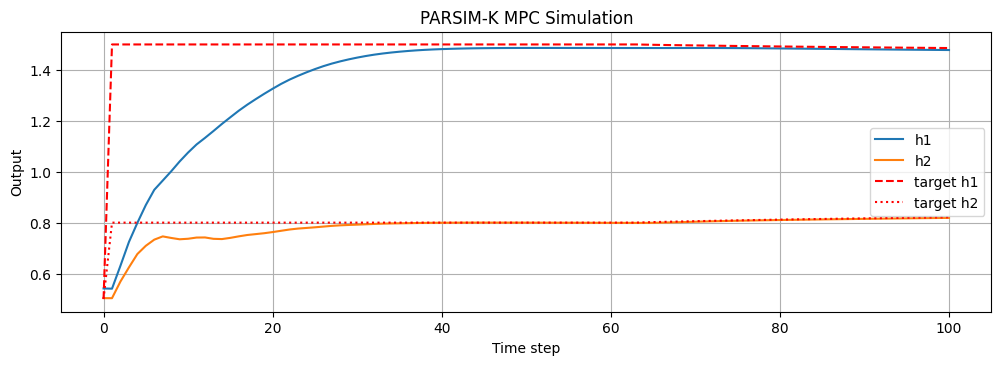

In [114]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0,50:], label='h1')
plt.plot(y_sim_descaled[1,50:], label='h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0,50:], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1,50:], color='red', linestyle=':', label='target h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title('PARSIM-K MPC Simulation')
plt.legend()
plt.grid(True) 

In [115]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [116]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [117]:
from sklearn.metrics import mean_squared_error

# Descales ys_sim
ys_sim_descaled = scaler.inverse_transform(ys_sim.T).T

# Compute MSE for each output
mse_h1 = mean_squared_error(ys_sim_descaled[0], y_sim_descaled[0])
mse_h2 = mean_squared_error(ys_sim_descaled[1], y_sim_descaled[1])

print(f"MSE for h1: {mse_h1}")
print(f"MSE for h2: {mse_h2}")

MSE for h1: 0.040411569913454716
MSE for h2: 0.002348898560354357


In [118]:
from numpy import trapz

# Compute ISE for each output
ise_h1 = trapz((ys_sim_descaled[0] - y_sim_descaled[0])**2)
ise_h2 = trapz((ys_sim_descaled[1] - y_sim_descaled[1])**2)

print(f"ISE for h1: {ise_h1}")
print(f"ISE for h2: {ise_h2}")

ISE for h1: 6.102116715600911
ISE for h2: 0.3546809306331804


In [119]:
y_sim[:, k] - y_setpoint

array([-0.02428797,  0.02533529])

In [120]:
# Compute the closed-loop value of the objective function

objective_value = 0
for k in range(50,sim_time):
    y_diff = y_sim[:, k] - y_setpoint
    u_diff = u_sim[:, k]
    objective_value += y_diff.T @ Qy @ y_diff + u_diff.T @ Qu @ u_diff

print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 223.3425405050871


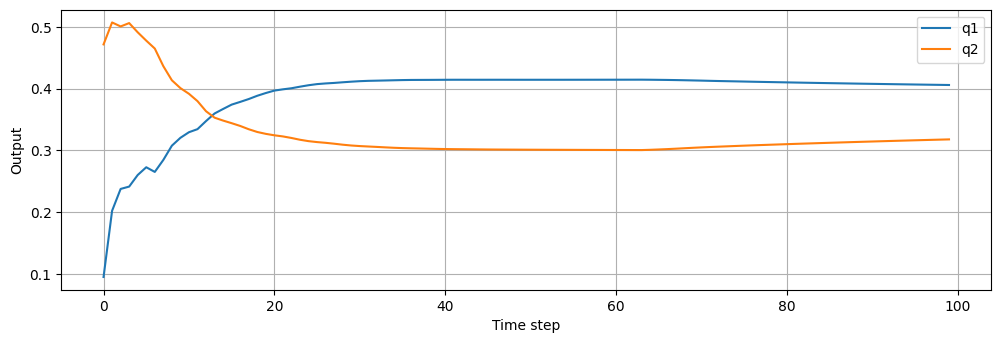

In [121]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0,50:], label='q1')
plt.plot(u_sim_descaled[1,50:], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [122]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[45.84605764 55.01253569]


/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_23997/621697738.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


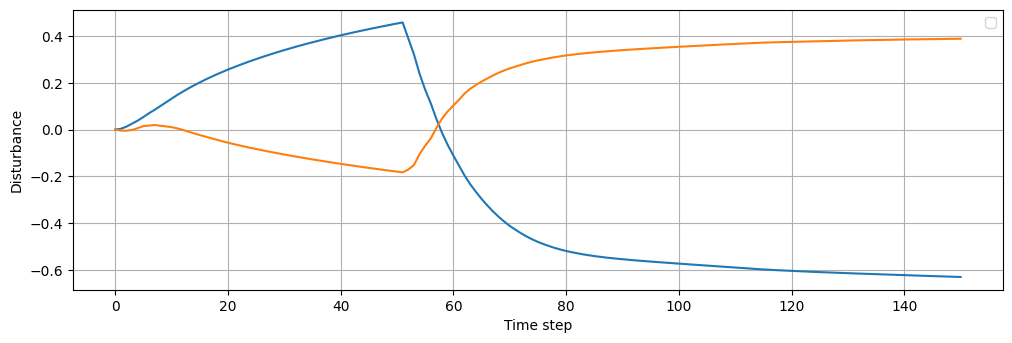

In [123]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[nz:].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_23997/126301668.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


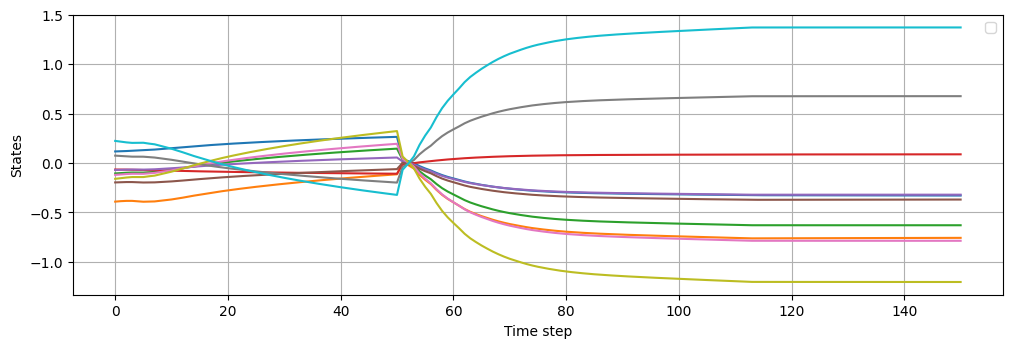

In [124]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(zs_sim[:nz].T)
plt.xlabel('Time step')
plt.ylabel('States')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_23997/4166394952.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


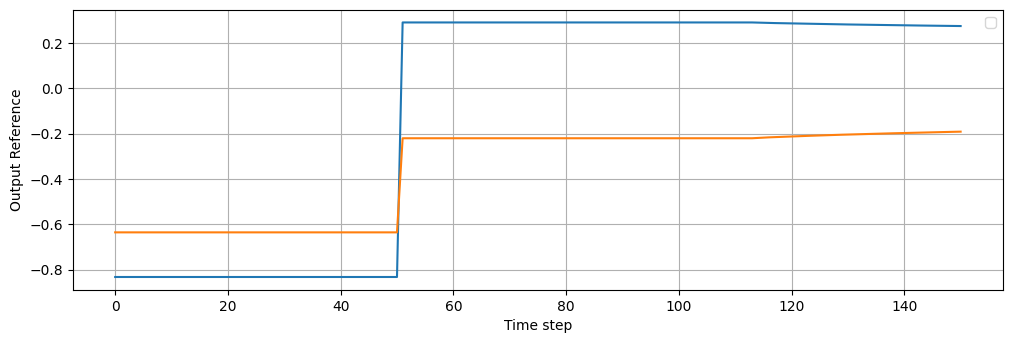

In [125]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ys_sim.T)
plt.xlabel('Time step')
plt.ylabel('Output Reference')
plt.legend()
plt.grid(True)